# EnviroMetaAnalysis

This notebook runs a network analysis to produce summary visualizations based on journal article metadata collected from `OpenAlex`. Running the `Alex2Mongo` pipeline is a prerequite, to query the OpenAlex API for article metadata, of articles within the selected *journals of interest*, and writes these metadata as documents to a `mongodb` database served in a `Docker` container. 

# Initialize Analysis

This notebook connects to the created `mongodb` database to garner insights into the global distribution of research efforts for various topics related to environmental science (as curated by the *journals of interest*). To run the notebook, one must simply set the variables in the cell below, and execute all the cells. 

**User Variable Descriptions**
- `target_concept` should be a lower case string keyword - to filter for article's with a related topic as provided by the `concept` metadata object. 
- `n_samples` is an integer - determines how large a sample size to use for the analysis. Larger number = longer runtimes! It is unlikely you will be able to compute the full dataset on a regular laptop, so sampling is a necessity. However, by the *Law of Large Numbers*, this should serve the analysis just fine. 

In [1]:
target_concept = 'environment'  # or 'all' for all of the samples...
n_samples = 10000

## Prepare Data

### GDP Data

The first step is to read-in GDP data and countries data. These economic data were gathered from the world bank and are read-in as excel spreadsheets. Because the GDP per capita (gdppc) varies across several orders of magnitude, the $\log(gdppc)$ is calculated for each country as well. The gdppc is used as a normalizations term, so the $\log(gdppc)$ is a better choice for us later on. 

In [2]:
import numpy as np
import pandas as pd

# read-in and clean income_level_data and gdp_per_capita

gdp_per_capita=pd.read_excel('../data/world bank GDP data.xls')
gdp_per_capita=gdp_per_capita.drop(columns={'Indicator Name', 'Country Name'})
gdp_per_capita=gdp_per_capita.rename(columns={'2022':'GDP per capita(US$)'})
gdp_per_capita=gdp_per_capita.drop_duplicates(subset=['Country Code'])

# gdp_per_capita

income_level_data=pd.read_excel('../data/world bank income division.xlsx')
income_level_data2=pd.read_excel('../data/world bank income2.xlsx')
income_level_data=income_level_data.drop(columns={'Income Group Code','Income Group'})
income_level_data=income_level_data.drop_duplicates()
income_level_data=income_level_data.merge(income_level_data2, right_on='Economy', left_on='Country')
income_level_data=income_level_data.drop(columns={'Economy'})

# income_level_data

country_stats = pd.merge(income_level_data, gdp_per_capita, left_on='Country Code', right_on='Country Code')
country_stats['log_gdppc'] = country_stats.apply(lambda row: np.log(row['GDP per capita(US$)']), axis=1)

print(country_stats)

    Country Code              Country         Income group  \
0            ASM       American Samoa          High income   
1            AND              Andorra          High income   
2            ATG  Antigua and Barbuda          High income   
3            ABW                Aruba          High income   
4            AUS            Australia          High income   
..           ...                  ...                  ...   
211          VUT              Vanuatu  Lower middle income   
212          VNM              Vietnam  Lower middle income   
213          PSE   West Bank and Gaza  Upper middle income   
214          ZMB               Zambia  Lower middle income   
215          ZWE             Zimbabwe  Lower middle income   

     GDP per capita(US$)  log_gdppc  
0           15743.310758   9.664171  
1           41992.793358  10.645253  
2           18745.173509   9.838692  
3           29342.100730  10.286779  
4           64491.429886  11.074288  
..                   ...   

### Connect to `mongodb`

The next step is to read-in the data from the `mongodb`. Remember! you will have hade to successfully executed the `Alex2Mongo.py` pipeline and created a `mongodb` database server in a `docker` container running on port `27017`. You may also have to update the database client and collection names. 

In [3]:
%%time

# first connect to the docker container with all the right fields
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

uri = "mongodb://localhost:27017/?retryWrites=true&w=majority"
client = MongoClient(uri, server_api=ServerApi('1'))
database = client["test_db"]
collection = database["journals"]

print(f"Total number of Articles: {collection.count_documents({})}")

# collection.find_one()

Total number of Articles: 1039248
CPU times: user 204 ms, sys: 59.2 ms, total: 263 ms
Wall time: 24.2 s


## Aggregate data for network edges

### Concepts Pipeline

The `concepts_pipeline` gets a list of article ids for each concept from a random sampling of articles, set by the `n_samples`.

In [4]:
%%time

import pandas as pd

# pipeline to get all concepts for all articles
concepts_pipeline = [
    {
        '$sample': { 'size': n_samples } 
    },
    {
        '$unwind': '$concepts'
    },
    {
        '$project': {
            '_id': 1,
            'type': 1,
            'concept': '$concepts.display_name'
        }
    },
    {
        '$match': {
            'type': 'article',
            'concept': {'$exists': True}
        }
    },
    {
        '$group': {
            '_id': '$concept',
            'article_ids': { '$addToSet': '$_id' }
        }
    },
    {
        '$project': {
            '_id': 1, 
            'article_ids': 1
        }
    }
]

# Execute the aggregation pipeline
concepts_result = collection.aggregate(concepts_pipeline)

# concepts_result.__dict__

concepts_results_list = []

# Iterate through the result and populate the list
for entry in concepts_result:
    try:
        concepts_results_list.append({
            'concept': entry['_id'],
            'article_ids': entry['article_ids']
        })
    except:
        continue

# Create a Pandas DataFrame from the results list
concepts_df = pd.DataFrame(concepts_results_list).sort_values(by='concept')
concepts_df['concept'] = concepts_df['concept'].str.lower()
concepts_df.set_index('concept', inplace=True)

# print(concepts_df)
print(len(set(concepts_df.index)))

12051
CPU times: user 221 ms, sys: 16.5 ms, total: 238 ms
Wall time: 7.06 s


Run this next cell if you want to see a list of all the concepts. Warning! The output is long....

In [5]:
# pprint(set(concepts_df.index))

The `concepts_df` results are filtered by the `target_concept` to select the ObjectIds only of the articles with concepts like the `target_concept`.

In [6]:
%%time

import itertools
import pandas as pd 

unique_ids = list(set(itertools.chain.from_iterable(list(concepts_df['article_ids']))))
if target_concept=='all':
    id_list = list(set(itertools.chain.from_iterable(list(concepts_df['article_ids']))))
else:
    id_list = list(set(itertools.chain.from_iterable(list(concepts_df.filter(like=str(target_concept).lower(), axis=0)['article_ids']))))

print(f'unique articles sampled: {len(unique_ids)}')
print(f'articles like "{target_concept}": {len(id_list)}')

unique articles sampled: 9930
articles like "environment": 6182
CPU times: user 77.9 ms, sys: 2.23 ms, total: 80.1 ms
Wall time: 78.7 ms


### Article Pipeline

The `article_pipeline` gets the publication year for each article, and other citation metrics:

- `cited_by_count` is the total number of citations for the article
- `coauthor_count` is the number of coauthors on the article
- `cites_per_coauthor` is calculated as:

$$
\text{cites_per_coauthor} = 
\begin{cases}
    \text{coauthor_count} > 0 & \frac{\text{cited_by_count}}{{\text{coauthor_count}\choose{2}} \times 2} \\
    \text{coauthor_count} = 0 & \frac{\text{cited_by_count}}{2}
\end{cases}
$$

In this case, the number of citations for a given article is divided by the number of possible combinations of coauthor pairs. For articles with only 1 coauthor, it is divided by 2. This prepares for weighting an edgelist for the network plots because for each article, the sum of the `cites_per_author` is made for *each pair of coauthors*. In this way, the total citations for all the author pairs will sum to the total citations for the given article. In the `author_pipeline`, single authors are duplicated; in this way, they are counted as *self-loops* in the network instead of being dropped, thus the denominator for this special case must just be 2.

In [7]:
%%time

import math
import pandas as pd

# pipeline to determine attributes for each article
article_pipeline = [
    {
        '$match': {
            '_id': {'$in': id_list},
            'type': 'article'
        }
    },
    {
        '$unwind': '$authorships'
    },
    {
        '$project': {
            '_id': 1,
            'type': 1,
            'publication_year': 1,
            'cited_by_count': 1,
            'country_code': {
                '$arrayElemAt': ['$authorships.institutions.country_code', 0]
            }
        }
    },
    {
        '$match': {
            'country_code': {'$exists': True}
        }
    },
    {
        '$group': {
            '_id': '$_id',
            'publication_year': {'$first':'$publication_year'},
            'cited_by_count': {'$first':'$cited_by_count'},
            'coauthor_count': {'$sum': 1}
        }
    },
    {
        '$project': {
            '_id': 1,
            'publication_year': 1,
            'cited_by_count': 1,
            'coauthor_count': 1
        }
    }
]

# Execute the aggregation pipeline
article_result = collection.aggregate(article_pipeline)

# article_result.__dict__

article_results_list = []

# Iterate through the result and populate the list
for entry in article_result:
    try:
        article_results_list.append({
            'pub_id': entry['_id'],
            'pub_year': entry['publication_year'],
            'cited_by_count': entry['cited_by_count'],
            'coauthor_count': entry['coauthor_count']
        })
    except:
        continue

# Create a Pandas DataFrame from the results list
article_df = pd.DataFrame(article_results_list)

article_df['cites_per_coauthor'] = article_df.apply(
    lambda row: row['cited_by_count']/(math.comb(row['coauthor_count'],2)*2) if math.comb(row['coauthor_count'],2)>0 else row['cited_by_count']/2, 
    axis=1
)
article_df.replace({'cites_per_coauthor': 0.}, 0.01, inplace=True)

# Display the DataFrame
print(article_df.sort_values('cites_per_coauthor'))

# article_result.__dict__

                        pub_id  pub_year  cited_by_count  coauthor_count  \
3556  64d2fabdadb21da659ae88a2      2022               8              60   
4491  64d307d5adb21da659b57810      2022               2              24   
392   64d2fce1adb21da659af9d10      2022               1              16   
2510  64d2f8aaadb21da659ad887a      2023               1              14   
5847  64d2fa8eadb21da659ae71d7      2022               1              14   
...                        ...       ...             ...             ...   
2659  64d302c5adb21da659b2a1b6      2013             692               3   
4980  64d308a9adb21da659b5e47d      2013             259               2   
3653  64d3095aadb21da659b63e14      2013             275               1   
613   64d2f9d1adb21da659ae11e2      2017             322               1   
2812  64d2ff0badb21da659b0cf98      2017             941               2   

      cites_per_coauthor  
3556            0.002260  
4491            0.003623  
392   

### Author Pipeline

The `author_pipeline` gets the country code and position for all of the coauthors of each article. Articles with single authors are duplicated for network plotting as a *self-loop*. The result is a complete list of attributes for all the coauthors on all the queried articles.

In [8]:
%%time

import pandas as pd
from iso3166 import countries

# this pipeline gets countries and positions of all authors

author_pipeline = [
    {
        '$match': {'_id': {'$in': id_list}}
    },
    {
        '$unwind': '$authorships'
    },
    {
        '$project': {
            '_id': 1,
            'type': 1,
            'country_code': {
                '$arrayElemAt': ['$authorships.institutions.country_code', 0]
            },
            'author_position': '$authorships.author_position'
        }
    },
    {
        '$match': {
            'type': 'article',
            'country_code': {'$exists': True}
        }
    }
]

# Execute the aggregation pipeline
author_result = collection.aggregate(author_pipeline)

# result.__dict__

# Create a list to store the results
author_results_list = []

# Iterate through the result and populate the list
for entry in author_result:
    try:
        author_results_list.append({
            'pub_id': entry['_id'],
            'country_code': countries.get(entry['country_code']).alpha3,
            'author_position': entry['author_position']
        })
    except:
        continue

# Create a Pandas DataFrame from the results list
author_df = pd.DataFrame(author_results_list)

# duplicate the single author rows - this gets the self-loops for the network plots
duplicated_pubs = author_df[author_df.duplicated(subset='pub_id', keep=False)]['pub_id']
singleauthor_rows = author_df[~author_df['pub_id'].isin(duplicated_pubs)]
author_df = pd.concat([author_df, singleauthor_rows], axis=0, ignore_index=True)

# Display the DataFrame
print(author_df)

                         pub_id country_code author_position
0      64d2f6daadb21da659ac9f47          MYS           first
1      64d2f6daadb21da659ac9f47          MYS          middle
2      64d2f6daadb21da659ac9f47          MYS          middle
3      64d2f6daadb21da659ac9f47          MYS          middle
4      64d2f6daadb21da659ac9f47          MYS          middle
...                         ...          ...             ...
31668  64d31416adb21da659bc247b          RUS           first
31669  64d31417adb21da659bc2530          RUS           first
31670  64d31417adb21da659bc2598          IDN           first
31671  64d3142dadb21da659bc307d          IDN           first
31672  64d314d4adb21da659bc7899          NGA           first

[31673 rows x 3 columns]
CPU times: user 164 ms, sys: 19.4 ms, total: 183 ms
Wall time: 509 ms


### Compile Edgelists from Pipeline Results

This is the main computational bottleneck of the program. For ultimate flexibility, the results of the concepts and article pipelines are left-joined onto the author pipelineto create a massive single edgelist dataframe. From this point, the `author_pairs` are reduced into simpler $3 \times n$ edgelist dataframes which can be read by the `nx.read_pandas_edgelist` method. 

Edglists are compiled in two formats: for grouping the nodes by *income group* or by *country code*. In the basic edgelist computation, the count of the number of author pairs for each grouping is aggregated. Although the count aggregation of the coauthors is a more easily understood metric, it skews the results toward countries with large populations, or greater resources to fund research (IE greater GDP). Thus, it is necessary to calculate a new metric that addresses these shortcomings. 

Recall, the `cites_per_coauthor` metric is calculated for each article, and is now joined to each coauthor in each coauthor pair. This addresses countries with large numbers of researchers by wdistributing the weight (number of citations the coauthored article has garnered) amongst all the coauthors. This is then normalized again by the $\log(gdppc)$ of the country of each coauthor in the coauthor pair:

$$
\text{cites_norm_gdppc} = 
\begin{cases}
    \text{coauthor_count} > 0 & \frac{\text{cited_by_count}}{{\text{coauthor_count}\choose{2}} \times 2} / \log(gdppc) \\
    \text{coauthor_count} = 0 & \frac{\text{cited_by_count}}{2} / \log(gdppc)
\end{cases}
$$

With this new metric computed for each coauthor in the coauthor pair, it is then summed as `cites_norm_gdppc_sum` for use in the edgelist. 

In [9]:
%%time

import itertools
import pandas as pd 

author_pair_list = list(itertools.chain.from_iterable([
    list(itertools.combinations(author_df[author_df['pub_id']==pub_id].index,2))
    for pub_id in set(author_df['pub_id'])
]))

author_pairs_newindex = pd.DataFrame(index=pd.MultiIndex.from_tuples(author_pair_list, names=('n1', 'n2'))).reset_index()
authors_articles = pd.merge(author_df,article_df,how='left',on='pub_id').reset_index()
author_article_node1 = pd.merge(author_pairs_newindex, authors_articles, how='left', left_on='n1', right_on='index')
author_article_country_node1 = pd.merge(author_article_node1, country_stats, how='left', left_on='country_code', right_on='Country Code')
author_article_country_node1['cites_norm_gdppc_x'] = author_article_country_node1.apply(lambda row: row['cites_per_coauthor'] / row['log_gdppc'], axis=1)
author_article_node2 = pd.merge(author_article_country_node1, authors_articles, how='left', left_on='n2', right_on='index')

author_pairs = pd.merge(author_article_node2, country_stats, how='left', left_on='country_code_y', right_on='Country Code')
author_pairs['cites_norm_gdppc_y'] =  author_pairs.apply(lambda row: row['cites_per_coauthor_y'] / row['log_gdppc_y'], axis=1)

print('author pairs count:')
print(author_pairs)

country_pairs_count = pd.DataFrame(author_pairs, columns=['country_code_x','country_code_y']).value_counts(subset=['country_code_x','country_code_y'])\
                        .reset_index(name='count').rename(columns={'country_code_x':'node1','country_code_y':'node2'})

print('\ncountry pairs count:')
print(country_pairs_count)

ig_pairs_count = pd.DataFrame(author_pairs, columns=['Income group_x','Income group_y']).value_counts(subset=['Income group_x','Income group_y'])\
                   .reset_index(name='count').rename(columns={'Income group_x':'node1','Income group_y':'node2'})

print('\nincome group pairs count:')
print(ig_pairs_count)

country_pairs_norm = author_pairs.groupby(['country_code_x','country_code_y']).aggregate({'cites_norm_gdppc_x': 'sum', 'cites_norm_gdppc_y': 'sum'})\
                                 .reset_index().rename(columns={'country_code_x':'node1','country_code_y':'node2'})
country_pairs_norm['cites_norm_gdppc_sum'] = country_pairs_norm.apply(lambda row: (row['cites_norm_gdppc_x'] + row['cites_norm_gdppc_y']), axis=1)
country_pairs_norm.drop(['cites_norm_gdppc_x','cites_norm_gdppc_y'], axis=1, inplace=True)

print('\ncountry pairs normalized:')
print(country_pairs_norm.sort_values('cites_norm_gdppc_sum', ascending=False))

ig_pairs_norm = author_pairs.groupby(['Income group_x','Income group_y']).aggregate({'cites_norm_gdppc_x': 'sum', 'cites_norm_gdppc_y': 'sum'})\
                            .reset_index().rename(columns={'Income group_x':'node1','Income group_y':'node2'})
ig_pairs_norm['cites_norm_gdppc_sum'] = ig_pairs_norm.apply(lambda row: (row['cites_norm_gdppc_x'] + row['cites_norm_gdppc_y']), axis=1)
ig_pairs_norm.drop(['cites_norm_gdppc_x','cites_norm_gdppc_y'], axis=1, inplace=True)

print('\nincome group pairs normalized:')
print(ig_pairs_norm.sort_values('cites_norm_gdppc_sum', ascending=False))

author pairs count:
          n1    n2  index_x                  pub_id_x country_code_x  \
0       3095  3096     3095  64d2f92aadb21da659adc958            JPN   
1       8954  8955     8954  64d2fce1adb21da659af9cfd            CHN   
2       8954  8956     8954  64d2fce1adb21da659af9cfd            CHN   
3       8954  8957     8954  64d2fce1adb21da659af9cfd            CHN   
4       8955  8956     8955  64d2fce1adb21da659af9cfd            CHN   
...      ...   ...      ...                       ...            ...   
100590  2909  2911     2909  64d2f8f7adb21da659adaf1f            CHN   
100591  2909  2912     2909  64d2f8f7adb21da659adaf1f            CHN   
100592  2910  2911     2910  64d2f8f7adb21da659adaf1f            CHN   
100593  2910  2912     2910  64d2f8f7adb21da659adaf1f            CHN   
100594  2911  2912     2911  64d2f8f7adb21da659adaf1f            CHN   

       author_position_x  pub_year_x  cited_by_count_x  coauthor_count_x  \
0                  first        2023   

## Aggregate data for network nodes

### Country Article Pipeline

The `country_article_pipeline` is similar to the original `article_pipeline` aggregation. However, it queries the *country codes* instead of the publication years. It also calculates this column:

$$\text{avg_cites_per_coauthor} = \frac{\text{cited_by_sum}}{\text{coauthor_count}}$$

This differs from the similar field in `article_pipeline` since this is aggregated for the entire country and the article/author-level granularity of normalization is not required for this higher level metric. Instead, the total citations for each country are normalized by the total number of coauthors for a country. 

In [10]:
%%time

import pandas as pd
from iso3166 import countries

# pipeline to determine attributes for each article
country_article_pipeline = [
    {
        '$match': {
            '_id': {'$in': id_list},
            'type': 'article'
        }
    },
    {
        '$unwind': '$authorships'
    },
    {
        '$project': {
            '_id': 1,
            'type': 1,
            'cited_by_count': 1,
            'country_code': {
                '$arrayElemAt': ['$authorships.institutions.country_code', 0]
            }
        }
    },
    {
        '$match': {'country_code': {'$exists': True}}
    },
    {
        '$group': {
            '_id': '$country_code',
            'cited_by_sum': {'$sum': '$cited_by_count'},
            'coauthor_count': {'$sum': 1}
        }
    }
]

# Execute the aggregation pipeline
country_article_result = collection.aggregate(country_article_pipeline)

# article_result2.__dict__

country_article_results_list = []

# Iterate through the result and populate the list
for entry in country_article_result:
    try:
        country_article_results_list.append({
            'country_code': countries.get(entry['_id']).alpha3,
            'cited_by_sum': entry['cited_by_sum'],
            'coauthor_count': entry['coauthor_count']
        })
    except:
        continue

# Create a Pandas DataFrame from the results list
country_article_df = pd.DataFrame(country_article_results_list)
country_article_df['avg_cites_per_coauthor'] = country_article_df.apply(
    lambda row: row['cited_by_sum']/row['coauthor_count'], 
    axis=1
)
country_article_df.replace({'avg_cites_per_coauthor': 0.}, 0.01, inplace=True)
country_article_df = country_article_df.groupby('country_code').aggregate({
    'avg_cites_per_coauthor':'mean',
    'cited_by_sum':'sum',
    'coauthor_count':'sum'
}).reset_index()

# Display the DataFrame
print(country_article_df.sort_values('avg_cites_per_coauthor', ascending=False))

    country_code  avg_cites_per_coauthor  cited_by_sum  coauthor_count
39           EST              172.333333          2068              12
139          ZWE              149.000000           447               3
42           FJI              143.000000           143               1
23           CIV              143.000000           143               1
29           CUB              107.333333           644               6
..           ...                     ...           ...             ...
90           NCL                0.010000             0               2
86           MTQ                0.010000             0               1
17           BRB                0.010000             0               1
27           CPV                0.010000             0               1
0            AFG                0.010000             0               1

[140 rows x 4 columns]
CPU times: user 28.9 ms, sys: 4.82 ms, total: 33.8 ms
Wall time: 239 ms


In [11]:
# This is a QAQC cell. These country codes are not merging properly with the GDP data. 
# Just needs some more data cleaning, but we'll ignore it for now....
# missing country associations

[ c for c in country_article_df['country_code'] if c not in list(country_article_df.merge(country_stats, how='inner', left_on='country_code', right_on='Country Code')['country_code']) ]

['GLP', 'GUF', 'MTQ', 'TWN', 'VEN']

### Node Attributes

This section parses the country article pipeline result into dicts readable by `networkx` to assign node charateristics. Attributes are parsed for graphs of the country network, and the income group network. 

In [12]:
%%time 

from pprint import pprint
import pandas as pd

country_attrs = pd.merge(country_article_df, country_stats, how='left', left_on='country_code', right_on='Country Code')

country_node_attrs = {
  I: {
        'coauthor_count':int(country_attrs[country_attrs['country_code']==I]['coauthor_count']),
        'cited_by_sum':int(country_attrs[country_attrs['country_code']==I]['cited_by_sum']),
        'avg_cites_per_coauthor':round(float(country_attrs[country_attrs['country_code']==I]['avg_cites_per_coauthor']),3),
        'Income group': list(country_attrs[country_attrs['country_code']==I]['Income group'])[0]
     }
  for I in country_article_df['country_code']
}

ig_attrs = pd.merge(country_article_df, country_stats, how='left', left_on='country_code', right_on='Country Code') \
             .drop(columns={'Country Code','Country','country_code'}) \
             .groupby('Income group').agg({
                'coauthor_count':'sum',
                'cited_by_sum':'sum',
                'avg_cites_per_coauthor':'mean'
             }).reset_index()

ig_node_attrs = { 
  I: {
        'coauthor_count':int(ig_attrs[ig_attrs['Income group']==I]['coauthor_count']),
        'cited_by_sum':int(ig_attrs[ig_attrs['Income group']==I]['cited_by_sum']),
        'avg_cites_per_coauthor':round(float(ig_attrs[ig_attrs['Income group']==I]['avg_cites_per_coauthor']),3),
     }
  for I in ig_attrs['Income group']
}

# pprint(country_node_attrs)
pprint(ig_node_attrs)

{'High income': {'avg_cites_per_coauthor': 29.674,
                 'cited_by_sum': 500098,
                 'coauthor_count': 16826},
 'Low income': {'avg_cites_per_coauthor': 13.645,
                'cited_by_sum': 2869,
                'coauthor_count': 89},
 'Lower middle income': {'avg_cites_per_coauthor': 27.032,
                         'cited_by_sum': 46250,
                         'coauthor_count': 2022},
 'Upper middle income': {'avg_cites_per_coauthor': 21.29,
                         'cited_by_sum': 264351,
                         'coauthor_count': 12093}}
CPU times: user 198 ms, sys: 24.8 ms, total: 222 ms
Wall time: 206 ms


## Plots

### Network Plots

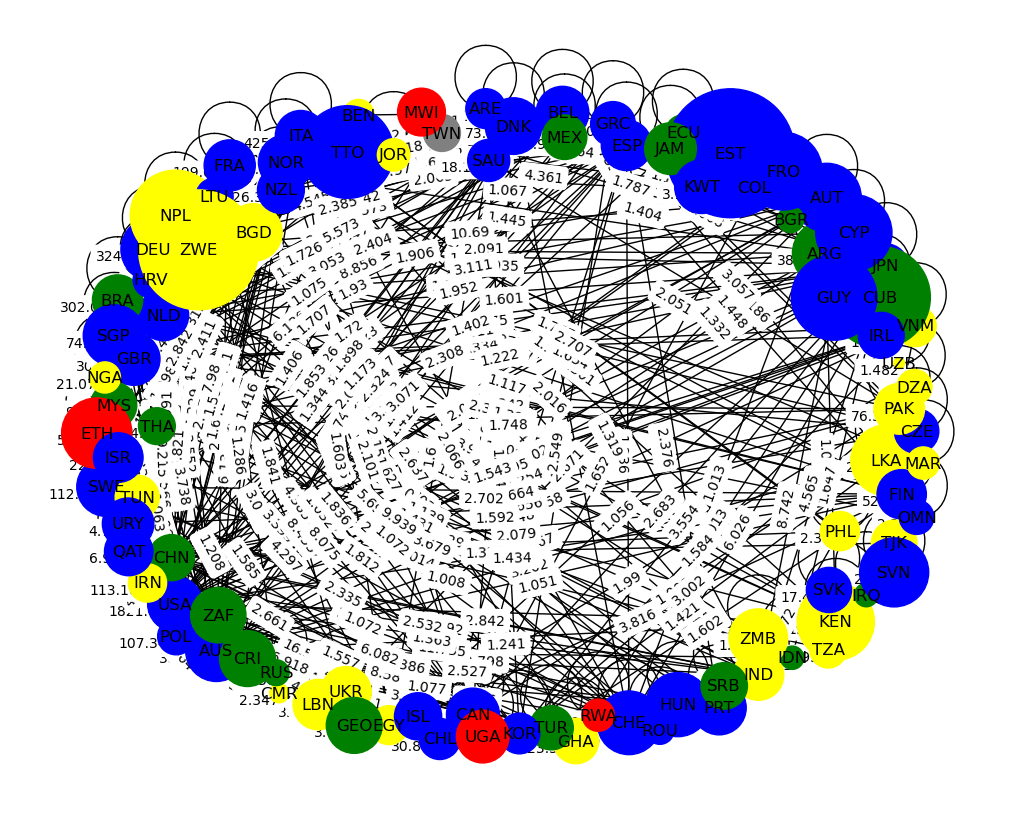

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
from pprint import pprint

country_graph = nx.from_pandas_edgelist(df=country_pairs_norm[country_pairs_norm['cites_norm_gdppc_sum']>1],
                                        source='node1', target='node2', edge_attr='cites_norm_gdppc_sum')
nx.set_node_attributes(country_graph, country_node_attrs)

nx.write_gexf(country_graph, f"gephi/country_graph-{target_concept}-{n_samples}.gexf")

# Set the background color to white
plt.rcParams['axes.facecolor'] = 'white'

# Expand the figure size for better visibility
plt.figure(figsize=(10, 8))

# Draw the graph with node sizes and red edges
pos = nx.spring_layout(country_graph, seed=42, k=10, iterations=50)
labels = {e: round(country_graph.edges[e]['cites_norm_gdppc_sum'],3) for e in country_graph.edges}
color_code = {
    'High income': 'blue',
    'Upper middle income': 'green',
    'Lower middle income': 'yellow',
    'Low income': 'red'
}
node_color = [ 'gray' if c is None else c for c in 
                [ color_code.get(country_graph.nodes[node]['Income group']) for node in country_graph.nodes() ]
             ]
node_size = [ country_graph.nodes[node]['avg_cites_per_coauthor'] * 50 for node in country_graph.nodes() ]

# pprint(labels)
# pprint(country_node_attrs)

nx.draw(country_graph, pos, node_size=node_size, node_color=node_color, with_labels=True)
nx.draw_networkx_edge_labels(country_graph, pos, edge_labels=labels, label_pos=0.5, 
                             horizontalalignment='right', verticalalignment='top')

# Show the graph
plt.show()

{('High income', 'High income'): 6840.314,
 ('High income', 'Low income'): 24.382,
 ('High income', 'Lower middle income'): 225.119,
 ('High income', 'Upper middle income'): 531.159,
 ('Low income', 'Low income'): 22.051,
 ('Low income', 'Lower middle income'): 2.074,
 ('Low income', 'Upper middle income'): 2.458,
 ('Lower middle income', 'Lower middle income'): 805.64,
 ('Lower middle income', 'Upper middle income'): 47.069,
 ('Upper middle income', 'Upper middle income'): 3989.325}
{'High income': {'avg_cites_per_coauthor': 29.674,
                 'cited_by_sum': 500098,
                 'coauthor_count': 16826},
 'Low income': {'avg_cites_per_coauthor': 13.645,
                'cited_by_sum': 2869,
                'coauthor_count': 89},
 'Lower middle income': {'avg_cites_per_coauthor': 27.032,
                         'cited_by_sum': 46250,
                         'coauthor_count': 2022},
 'Upper middle income': {'avg_cites_per_coauthor': 21.29,
                         'cited_by

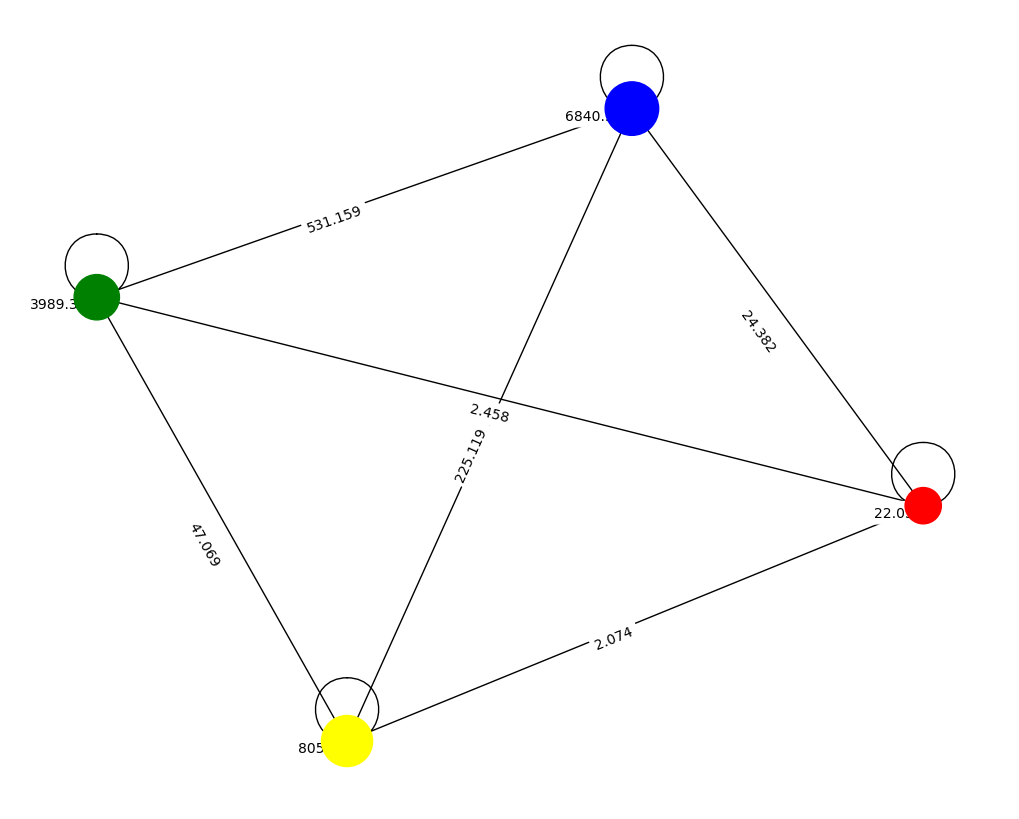

In [14]:
import matplotlib.pyplot as plt
import networkx as nx
from pprint import pprint

ig_graph = nx.from_pandas_edgelist(df=ig_pairs_norm, source='node1', target='node2', edge_attr='cites_norm_gdppc_sum')
nx.set_node_attributes(ig_graph, ig_node_attrs)

nx.write_gexf(ig_graph, f"gephi/ig_graph-{target_concept}-{n_samples}.gexf")

# Set the background color to white
plt.rcParams['axes.facecolor'] = 'white'

# Expand the figure size for better visibility
plt.figure(figsize=(10, 8))

# Draw the graph with node sizes and red edges
pos = nx.spring_layout(ig_graph, seed=42, k=10, iterations=50)
labels = {e: round(ig_graph.edges[e]['cites_norm_gdppc_sum'],3) for e in ig_graph.edges}
color_code = {
    'High income': 'blue', 
    'Upper middle income': 'green',
    'Lower middle income': 'yellow',
    'Low income': 'red'
}
node_color = [ 'gray' if c is None else c for c in 
                [ color_code.get(node) for node in ig_graph.nodes() ]
             ]
node_size = [ig_graph.nodes[node]['avg_cites_per_coauthor'] * 50 for node in ig_graph.nodes()]

pprint(labels)
pprint(ig_node_attrs)

nx.draw(ig_graph, pos, node_size=node_size, node_color=node_color, with_labels=False)
nx.draw_networkx_edge_labels(ig_graph, pos, edge_labels=labels, label_pos=0.5, 
                             horizontalalignment='right', verticalalignment='top')

# Show the graph
plt.show()

### Bar Plots

In [15]:
plotdf = pd.merge(country_article_df, country_stats, how='left', right_on='Country Code', left_on='country_code') \
           .drop(columns={'Country Code','Country','country_code'}) \
           .groupby('Income group').agg({'coauthor_count':'sum','cited_by_sum':'sum','avg_cites_per_coauthor':'mean'}) \
           .reset_index().melt(id_vars = ['Income group'], value_vars=['coauthor_count','cited_by_sum','avg_cites_per_coauthor'])

# plotdf

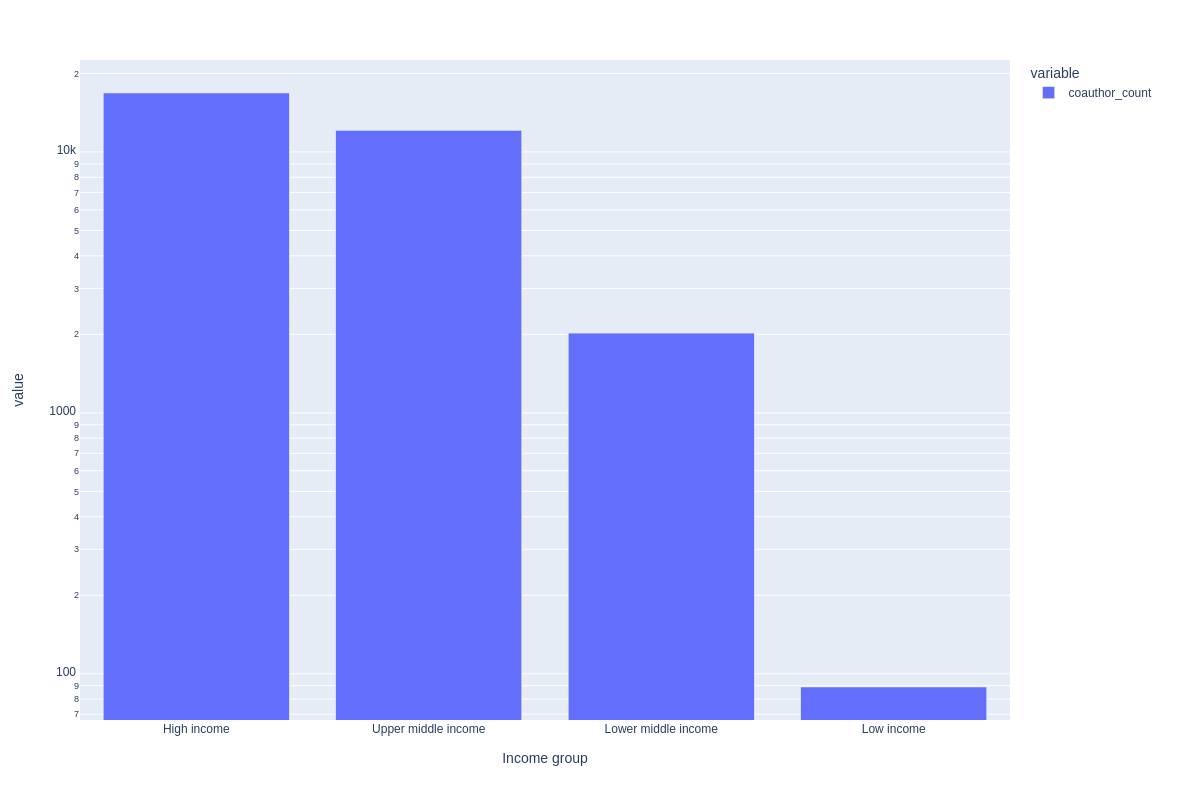

In [16]:
import plotly.express as px

fig = px.bar(plotdf[plotdf['variable']=='coauthor_count'], x="Income group", y='value', color='variable', log_y=True,
             category_orders={'Income group':['High income', 'Upper middle income', 'Lower middle income','Low income']}, width=1000, height=800)

fig.write_html(f"plots/coauthor_counts_ig-{target_concept}-{n_samples}.html")

fig.show()

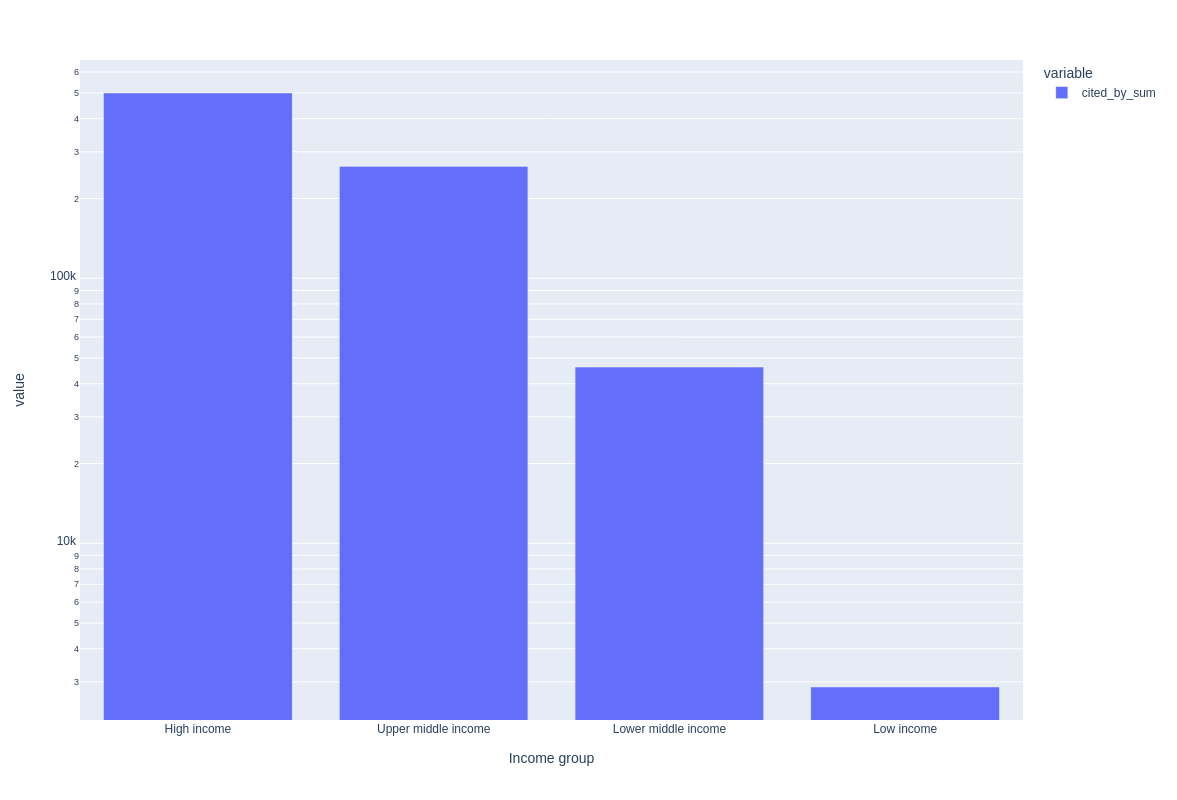

In [17]:
import plotly.express as px

fig = px.bar(plotdf[plotdf['variable']=='cited_by_sum'], x="Income group", y='value', color='variable', log_y=True,
             category_orders={'Income group':['High income', 'Upper middle income', 'Lower middle income','Low income']}, width=1000, height=800)

fig.write_html(f"plots/cited_by_sum_ig-{target_concept}-{n_samples}.html")

fig.show()

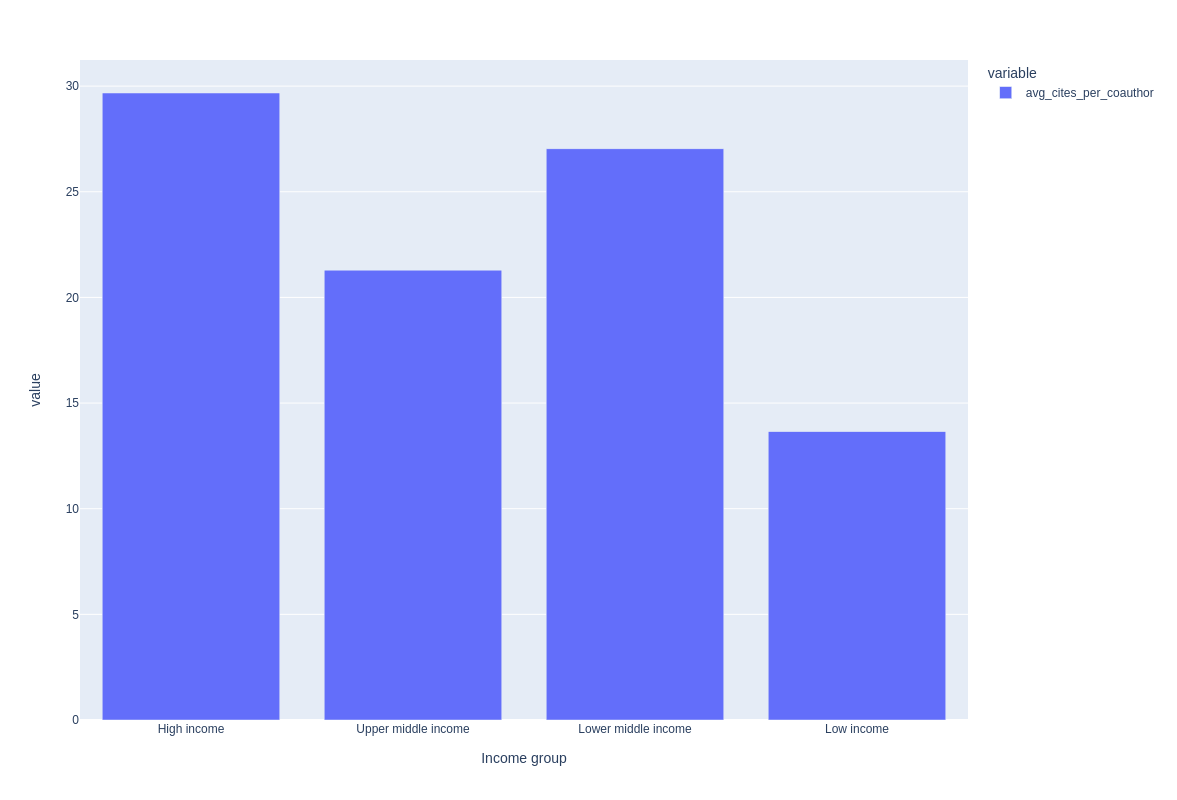

In [18]:
import plotly.express as px

fig = px.bar(plotdf[plotdf['variable']=='avg_cites_per_coauthor'], x="Income group", y='value', color='variable', 
             category_orders={'Income group':['High income', 'Upper middle income', 'Lower middle income','Low income']}, width=1000, height=800)

fig.write_html(f"plots/avg_cites_per_coauthor_ig-{target_concept}-{n_samples}.html")

fig.show()

### Choropleth Plots

In [19]:
import pandas as pd

choropleth_df = pd.merge(country_article_df, country_stats, how='left', left_on='country_code', right_on='Country Code')

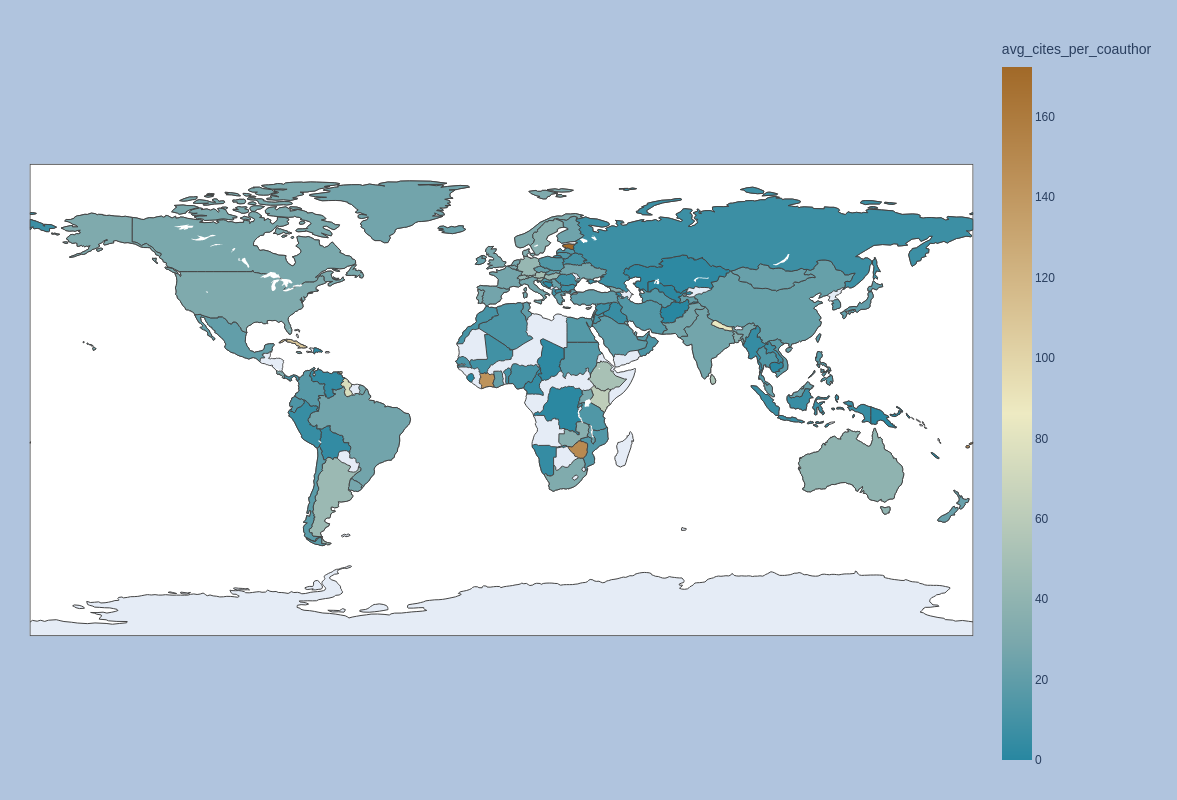

In [20]:
import plotly.express as px
import pandas as pd
import numpy as np

avg_avg_cites_per_coauthor = np.mean(choropleth_df['avg_cites_per_coauthor'])
max_avg_cites_per_coauthor = np.max(choropleth_df['avg_cites_per_coauthor'])

fig = px.choropleth(choropleth_df, locations="country_code",
                    color="avg_cites_per_coauthor",
                    range_color=(0,max_avg_cites_per_coauthor),
                    hover_name="Country",
                    width=1200, height=800,
                    color_continuous_scale=px.colors.diverging.Earth[::-1],
                    color_continuous_midpoint=avg_avg_cites_per_coauthor)

fig.update_layout(
    margin=dict(l=30, r=30, t=30, b=30),
    paper_bgcolor="LightSteelBlue",
)

fig.write_html(f"plots/avg_cites_per_coauthor_choropleth-{target_concept}-{n_samples}.html")

fig.show()

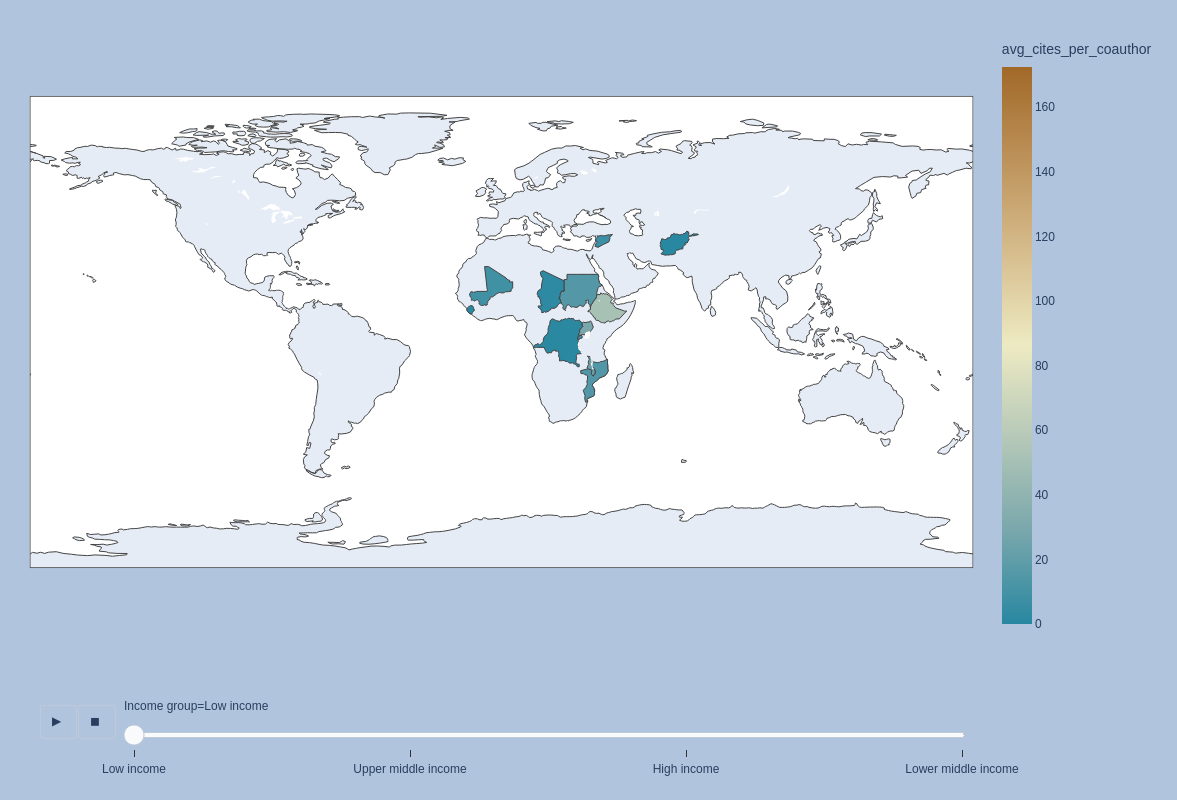

In [21]:
import plotly.express as px
import pandas as pd
import numpy as np

avg_avg_cites_per_coauthor = np.mean(choropleth_df['avg_cites_per_coauthor'])
max_avg_cites_per_coauthor = np.max(choropleth_df['avg_cites_per_coauthor'])

fig = px.choropleth(choropleth_df, locations="country_code",
                    color="avg_cites_per_coauthor",
                    range_color=(0,max_avg_cites_per_coauthor),
                    hover_name="Country",
                    width=1200, height=800,
                    animation_frame="Income group",
                    color_continuous_scale=px.colors.diverging.Earth[::-1],
                    color_continuous_midpoint=avg_avg_cites_per_coauthor)

fig.update_layout(
    margin=dict(l=30, r=30, t=30, b=30),
    paper_bgcolor="LightSteelBlue",
)

fig.show()

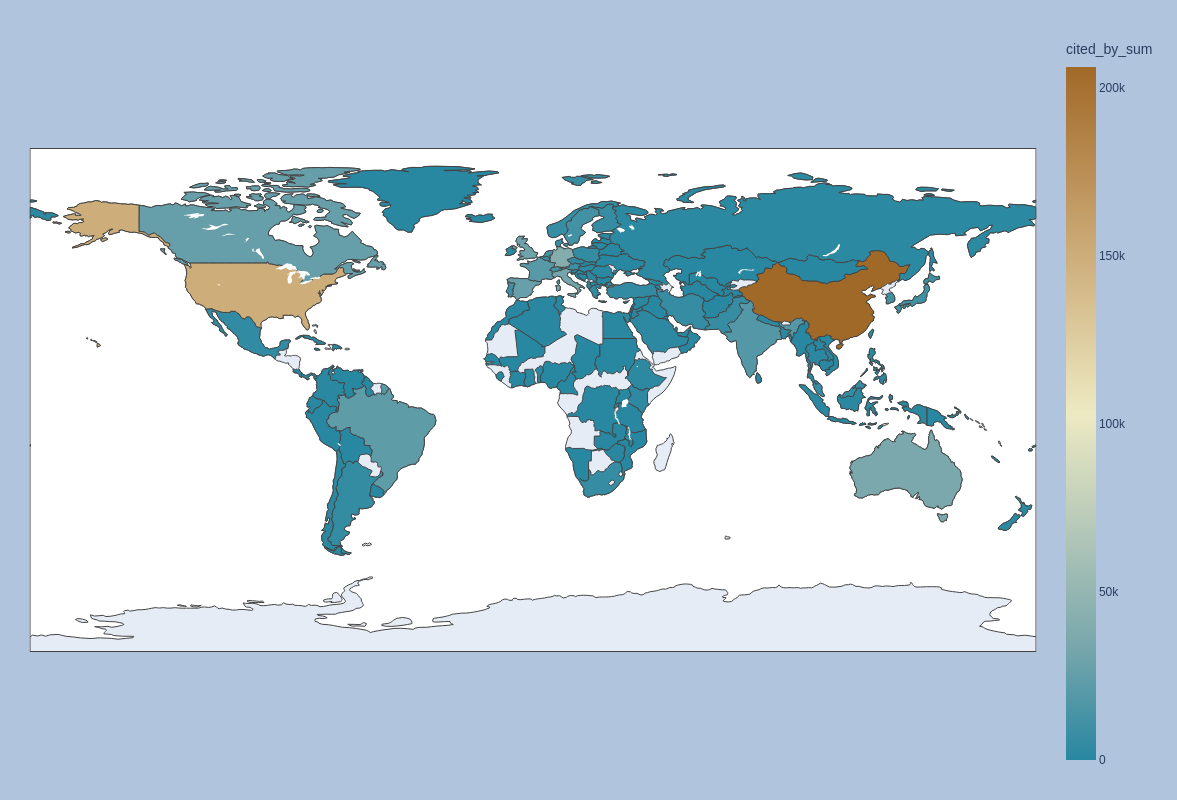

In [22]:
import plotly.express as px
import pandas as pd
import numpy as np

avg_avg_cited_by_sum = np.mean(choropleth_df['cited_by_sum'])
max_avg_cited_by_sum = np.max(choropleth_df['cited_by_sum'])

fig = px.choropleth(choropleth_df, locations="country_code",
                    color="cited_by_sum",
                    range_color=(0,max_avg_cited_by_sum),
                    hover_name="Country",
                    width=1200, height=800,
                    color_continuous_scale=px.colors.diverging.Earth[::-1],
                    color_continuous_midpoint=avg_avg_cited_by_sum)

fig.update_layout(
    margin=dict(l=30, r=30, t=30, b=30),
    paper_bgcolor="LightSteelBlue",
)

fig.write_html(f"plots/cited_by_sum_choropleth-{target_concept}-{n_samples}.html")

fig.show()